# Model training and testing

This notebook guides you through model training and testing.  
In general, the model performs a dimensionality reduction of the spectra into latent space.  
The dimensionality reduction consists by a transformation matrix `loadings_tr` that the spectra are fitted to, producing their latent-space representation, i.e. their `scores`. 

This model helps to analyze spectral data in the following ways:  
- **Classification** is done in latent space where each dimension corresponds to an isotope.    
Hence, the (normalized) scores are a direct measure for the contribution of the respective isotopes to the test spectrum.   
- **Denoising** is done by transforming the scores back into spectral space, which rids them of noise.   
- **Outlier Detection** is done by comparing the original and denoised spectrum quantitatively to understand if most information can be represented and transferred to latent space. If their similarity is low, the test spectrum cannot be decomposed by the loadings, making an outlier spectrum as it stems from an isotope not used in model training.  

The python library used for model training and testing is `tools_model.py` and all visualizations are specified in `plotting.py`.  
In addition, we use and define global variables from  `globals.py`.  
As we did in `01_preprocessing.ipynb`, we set names for the detectors used to measure/simulate spectra and save them as global variables.

In [1]:
from tools.tools_model import *
from tools.plotting import *
from tools.globals import GlobalVariables

dets_measured = ["left", "right"]
det_simulated = "simulated"

GlobalVariables.dets_measured = dets_measured
GlobalVariables.det_simulated = det_simulated

all_detectors = dets_measured + [det_simulated]
GlobalVariables.all_detectors = all_detectors

## Model training & evaluation (same detectors for training and test set)

#### Specify detectors, channels and scores detection threshold used for model training

Before we start, we need to specify which isotopes and detectors are used in model training.  
You should use only single-label spectra for training (e.g. pure isotope spectra that do not contain background).  
Hence, if your measured spectra from `dets_measured` contain background (as in our example), you should choose `dets_tr = ['simulated+bg']` to use simulated spectra for isotopes as well as pure measured background spectra.  
Technically, you could also set `dets_tr = ['simulated', 'left', 'right']` but it is not recommended.

In addition, you can specify if you want to use all channels of the spectra or if you want to ignore the lower channels.  
In our example, we set `min_channel=7` as for our spectrometers, as those channels are not reliable. Not setting a minimum channel may cause problems for model inference. 

The last parameter that has to be set is the detection threshold of the normalized scores.  
As an example, a value of `min_scores_norm = 0.1` means that all isotopes with contribution to the test spectrum lower than 10% will not be included in the prediction. 

The variables `dets_tr`, `min_channel_tr` and `min_scores_norm` are saved as global variables. 

In [2]:
dets_tr = [
    "simulated+bg"
]  # only simulated isotope spectra and pure measured backgrounds (default)
GlobalVariables.dets_tr = dets_tr

min_channel_tr = 7
GlobalVariables.min_channel_tr = min_channel_tr

min_scores_norm = 0.1
GlobalVariables.min_scores_norm = min_scores_norm

#### Loading, checking and splitting data

Now we are ready to load the preprocessed data from the directory `dir_numpy_ready`. We can specify the detectors and use only `dets_tr` for now.  
In our example, we are using all isotopes of this detector. If you choose to only use a subset of them, you can navigate this by the  
parameters `include_files` or `exclude_files` in `load_spectral_data()`. 

We can extract the isotopes used for model training to `isotopes_tr` and save them as a global variable. 

To ensure that our training data does not include any faulty or empty spectra, we remove those and count the number of spectra per isotope.  
As a rule of thumb, you should provide at least 500 spectra per isotope. 

The data are split into a training and validation set. Thus, the model is trained only on the training set and we can evaluate the inference on the validation set. 

In [3]:
# load spectra as list of dictionaries
data_sim_and_bg, isotopes_tr = load_spectral_data(
    dir_numpy_ready, GlobalVariables.dets_tr
)
isotopes_tr = [
    x[0] for x in isotopes_tr
]  # only single-label spectra allowed for model training
GlobalVariables.isotopes_tr = isotopes_tr
print(f"isotopes for training: ", GlobalVariables.isotopes_tr)

data_sim_and_bg = remove_empty_or_negative_spectra(data_sim_and_bg)
count_spectra_per_isotope(data_sim_and_bg)

data_train, data_val = split_train_test(data_sim_and_bg)

isotopes for training:  ['Am241', 'Co60', 'Cs137', 'Eu152', 'background']
['Am241']: 814 spectra
['Co60']: 1351 spectra
['Cs137']: 1230 spectra
['Eu152']: 1498 spectra
['background']: 1226 spectra


#### Training the model / Building the loadings matrix 
Let's start model training! In `train_dim_model`, a transformation matrix `loadings_tr` is built by calculating mean spectra for all `isotopes_tr` and stacking them.  
You can save it to `dir_trained_models` (You can specify the directory in `utils.py`. The default folder name is `trained_models`). Then you can load the trained model into your spectral measurement routine later on.  
In addition, you can plot the loadings, i.e. the mean spectra as subplots to ensure that they look as they should. 

Building loadings from mean spectra of those isotopes: ['Am241', 'Co60', 'Cs137', 'Eu152', 'background']
The trained model is saved to trained_models/trained_dim_model.
Saving figure to plots/Am241_Co60_Cs137_Eu152_background/Loadings_subplots_Am241_Co60_Cs137_Eu152_background.svg


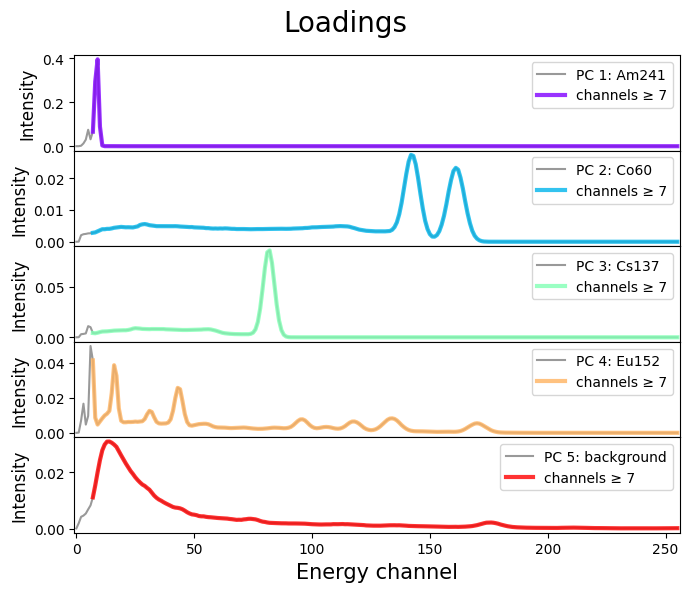

In [4]:
train_dim_model(data_train, save_results=True)

plot_loadings = True
if plot_loadings:  # option to visualize the loadings (mean spectra) in subplots.
    plot_loadings_subplots(save_plot=True)

#### Model inference / Calculating the scores matrix #### 
The trained dimensionality reduction model is used to transform spectra into latent space (yielding the scores) and back (yielding the denoised spectra).  
The scores are a compressed latent-space representation of the spectra where each spectrum is represented by a `n_isotopes_tr`-dimensional scores vector.  
Hence, in latent space, each dimension corresponds to one isotope. 

The explained variance ratio between the denoised and the original spectra is calculated.  
It serves as a measure for how much spectral information can be stored in latent space and should be above 80% to ensure good classification results.

We apply the model both to training and validation data.

In [5]:
data_tr = apply_dim_model(data_train)  # apply model to training data
data_test = apply_dim_model(data_val)  # apply model to validation data

Explained variance ratio:  91.0% 

Explained variance ratio:  91.2% 



#### Classification from scores #### 
The scores are used to predict labels for the validation data. The prediction is given by a dictionary in the form {isotope: score}, ordered by descending scores.  
It contains all predicted isotopes with scores above the threshold `min_scores_norm`. 

To quantify the model performance, the accuracy of the prediction over the whole test dataset is calculated.  
You can choose whether only the isotope with the highest score is considered (for single-label data, so `class_type = 'single-label'`) or if all predicted isotopes are included (for multi-label data, so `class_type = 'multi-label'`). 

In [6]:
class_type = "single-label"  # can be 'single-label' or 'multi-label'
data_val = classify_from_scores(data_val, class_type)

Single-label classification accuracy:  99.8%


#### Visualization of the classification results for validation data (same detector as used for model training)

The classification results can be visualized in various plots. You can choose which ones should be displayed in the dictionary `choose_plots`. 
1. `plot_confusion_matrix`: The classification accuracy is visualized for all isotopes as a confusion matrix.   
It helps to identify which isotopes have been confused. The parameter `class_type` controls whether only single-label predictions are considered or if all predictions are taken into account (multi-label). 

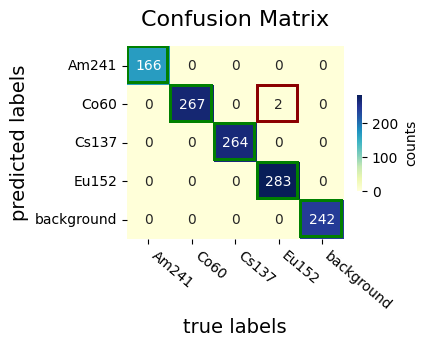

In [7]:
plot_confusion_matrix(
    data_val, class_type, save_plot=False
)  # confusion matrix of true and predicted labels

2. `plot_misclassified_spectra`: Some examples of misclassified spectra are displayed in subplots, where on the left side, the mean spectra of the true and predicted isotopes are shown and their scores are printed.  
On the right side, the denoised and the original spectra are shown and their cosine similarity is calculated.

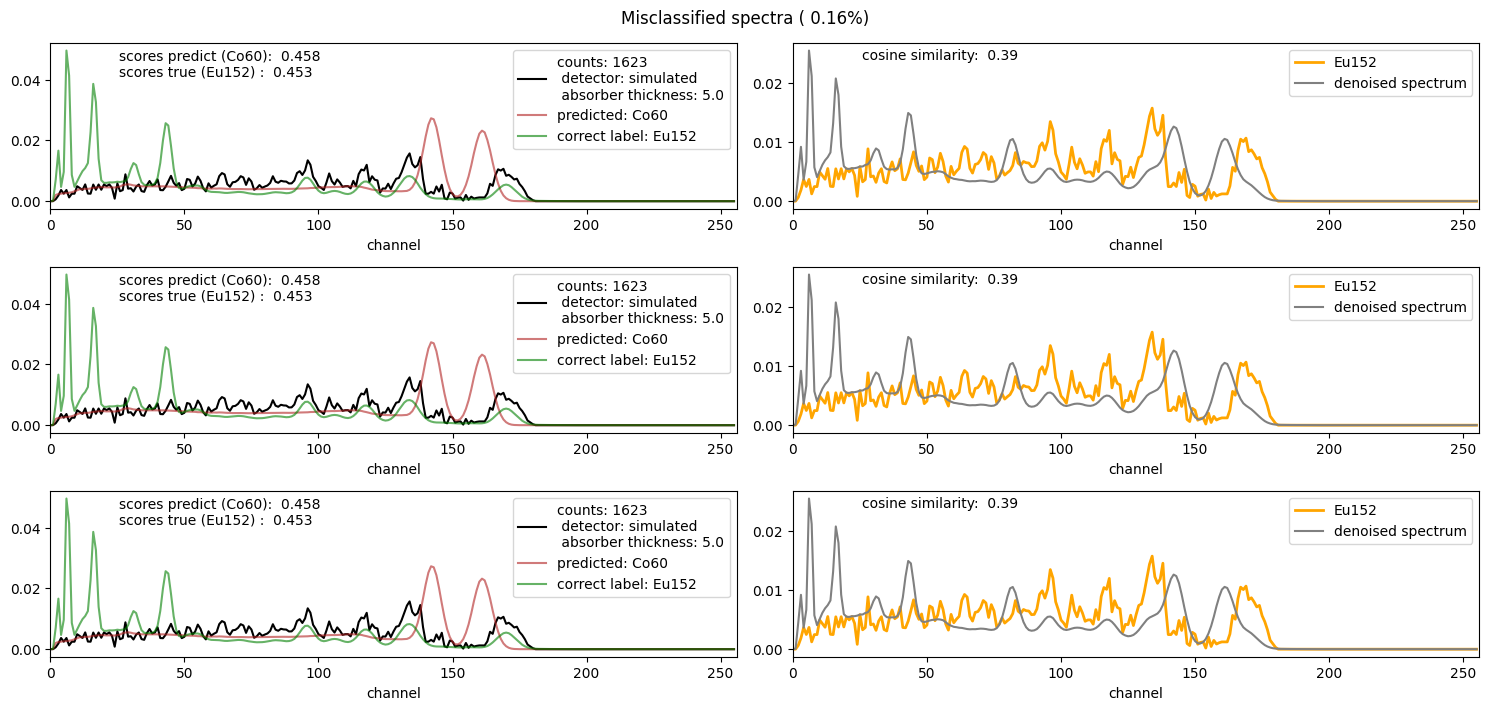

In [8]:
plot_misclassified_spectra(
    data_val, class_type, save_plot=False
)  # misclassified spectrum and true & predicted means, denoised spectrum

3. `plot_denoised_example_spectrum`: The original and denoised spectrum are plotted for a random example spectrum and their cosine similarity is printed. 

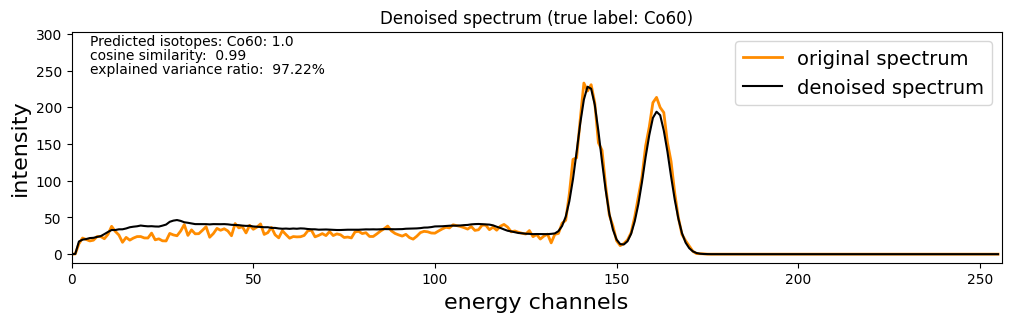

In [9]:
plot_denoised_spectrum_example(data_val)  # example spectrum (original & denoised)

4. `plot_misclassification_statistics`: For a thorough understanding of the misclassified spectra, the number of correct (green) and incorrect (red) classifications are visualized as histogram, depending on 
    - explained variance ratio (measure for the explained variance between original & denoised spectrum)
    - cosine similarity (measure for the similarity between original & denoised spectrum)
    - absolute value of scores vector (euclidian norm) to quantify if one element has a major share (e.g. scores=[1, 0, 0, 0, 0] -> ||scores|| = 1) or if all isotopes have some share (e.g. scores=[0.2, 0.2, 0.2, 0.2, 0.2] -> ||scores||=0.45). 
    - integral of the spectrum (number of counts), e.g. to reveal if spectra with too few counts are more likely to be misclassified

    In addition, a threshold can be adjusted for each subplot. It can serve as a decision boundary in your measurement and classification routine, deciding whether to trust a prediction or not.  
    As an example, if the accuracy improves significantly when only predictions with `cosine similarity > 0.85` are considered, you can memorize this for your measurement routine.  
    Feel free to alter the thresholds in `plot_misclassification_statistics` in `plotting.py`.



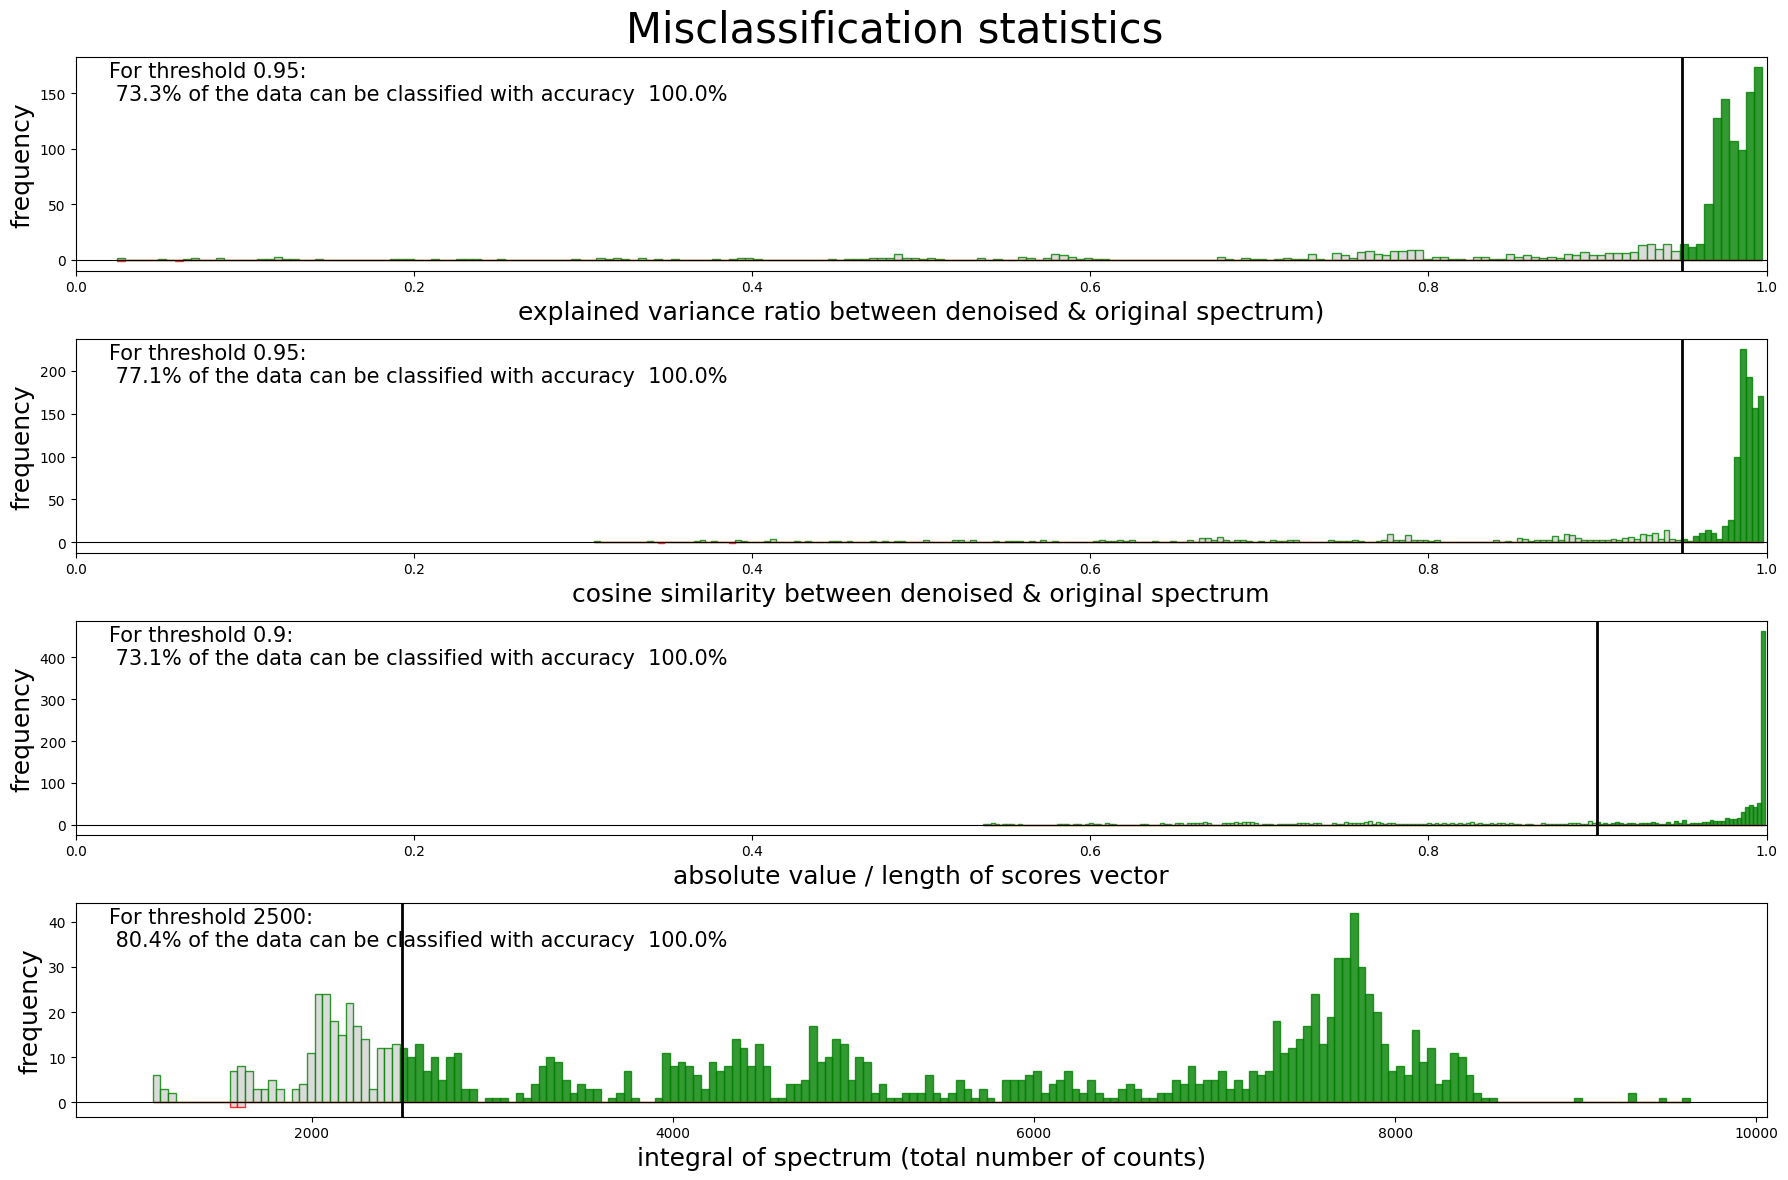

In [10]:
plot_misclassification_statistics(
    data_val, class_type
)  # histogram of correct & incorrect classifications

5. `plot_scores_scatter_matrix`: Visualize your spectra in latent space as a scatter matrix.  
For `n_isotopes_tr`, this results in an `n_isotopes_tr - 1` dimensional matrix of subplots where only the lower triangle is displayed.  
Scores of training data are plotted as small points, colored by their (true) label. Scores of test data are depicted as larger points with black edges.  
You can choose to show only misclassified data (`only_errs=True`, default) or any test data in `plot_classification_results` in `plotting.py`. 



In plot_scores_scatter_matrix, only misclassified test data are displayed.
Saving figure to plots/Am241_Co60_Cs137_Eu152_background/Scores_in_scatter_matrix_Am241_Co60_Cs137_Eu152_background.svg


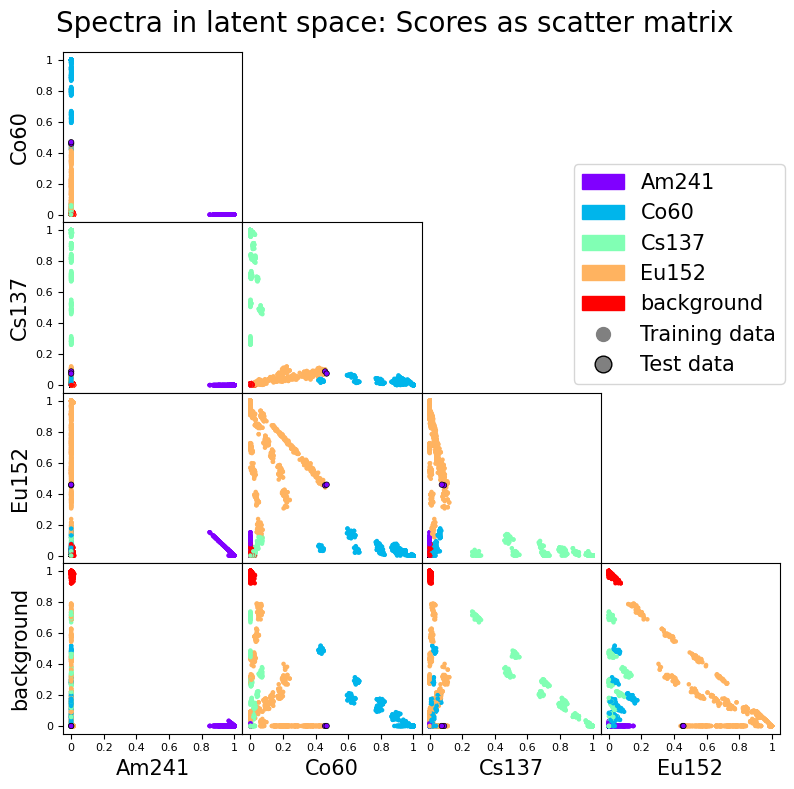

In [11]:
plot_scores_scatter_matrix(
    data_tr, data_val, class_type, n_dim_max=6, only_errs=True, save_plot=True
)  # scatter matrix of scores (data in latent space)

6. `plot_scores_barplot`: Visualize the mean of the scores by isotope in a bar plot, with the latent space isotope axes serving as x axes.  
Multi-label data containing more than one isotope are ignored, only single-label data or the combination of one isotope + background are considered.  
For single-label classification of spectral data not containing background, this should lead to distinct bars, each isotope having values close to 1 for its corresponding isotope axis in latent space.  
In our example, we can see that this works very well for Am241 while for Eu152, the mean scores also contain parts of other isotope axes.  
As the components of the loadings matrix (mean spectra of isotopes) are not necessary linear independent, a high similarity between them may lead to confusion.  
This plot reveals which isotopes can be clearly distinguished and which may be mistaken.

ratio of mean Am241 scores on Am241 axis: 0.98
ratio of mean Co60 scores on Co60 axis: 0.92
ratio of mean Cs137 scores on Cs137 axis: 0.9
ratio of mean Eu152 scores on Eu152 axis: 0.76
ratio of mean background scores on background axis: 0.98


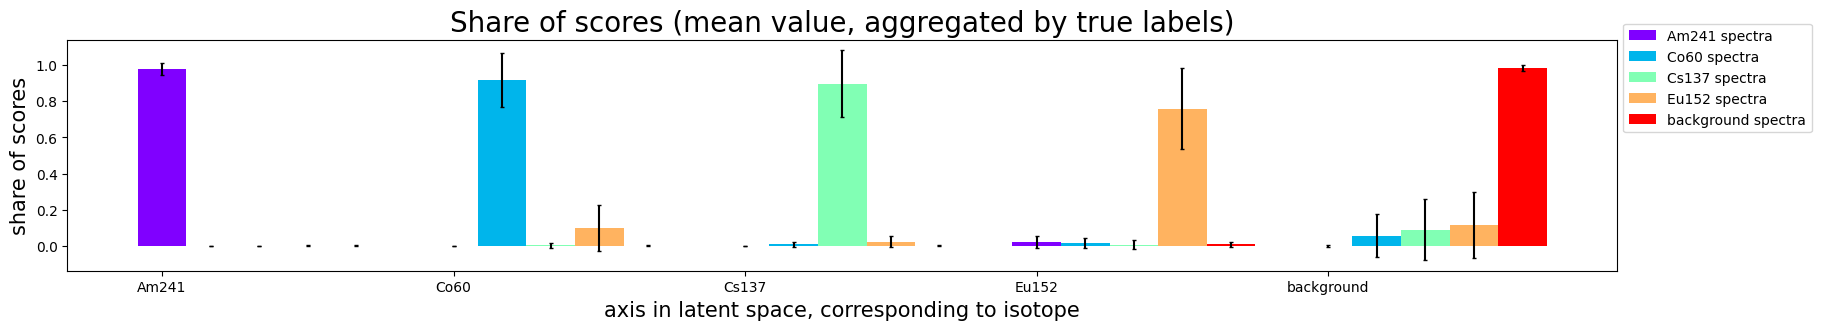

In [12]:
plot_mean_scores_barplot(
    data_val, class_type, save_plot=False
)  # barplot of mean scores (for all isotopes)

## Testing the model on spectral data from a different detector (single-label spectra only) ##
In some cases, spectral data from the detector used to measure the test data (`dets_te`) is not available for model training.  
To simulate this situation, we train the model on data from `dets_tr` and analyze its performance on an unknown test dataset from `dets_te`.  
In our example, we train on simulated data and pure background, i.e. `dets_tr = ['simulated+bg']` and test on measured data from the right and left detector, i.e. `dets_te = ['left', 'right']`.  
To do this, we run through the following steps: 

- As we have already trained the model above, we can start by loading the test data `data_test` where we only include spectra from `dets_te` and only use single-label spectra for now. 
- We filter out all spectra in the test dataset from isotopes that are unknown to the model as they were not used in model training. 
- We limit the number of spectra per isotope to ensure similar sizes of datasets for all isotopes.  
- Now we can start with the transformation of the test dataset into latent space (calculate scores) and classify the spectra.
- At last, we can visualize the results in different plots.

['Am241', 'background']: 71 spectra
['Co60', 'background']: 101 spectra
['Cs137', 'background']: 200 spectra
['Eu152', 'background']: 61 spectra
['background']: 567 spectra
explained variance ratio of unknown test dataset:  95.0%
Single-label classification accuracy:  95.2%
Saving figure to plots/Confusion_matrix_.svg


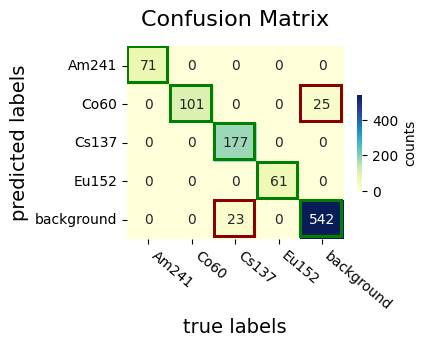

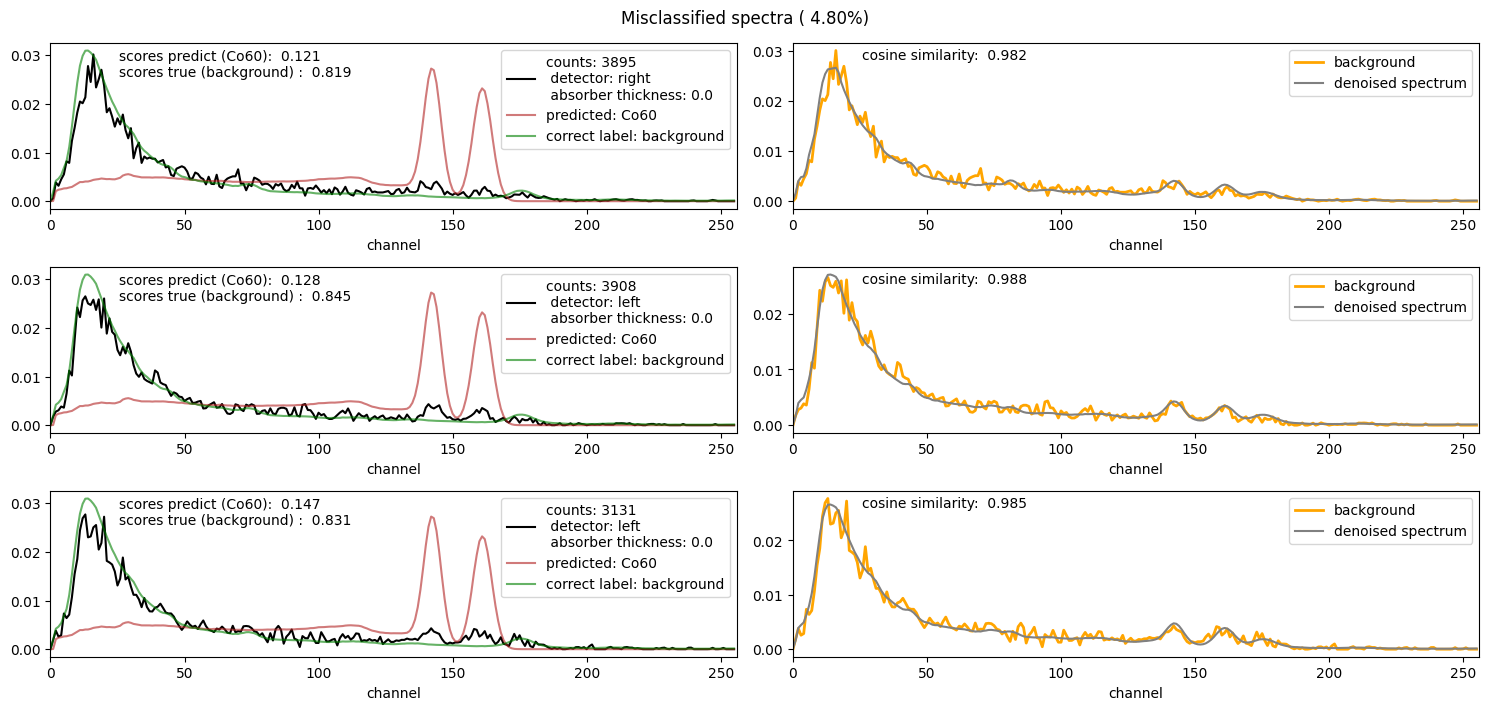

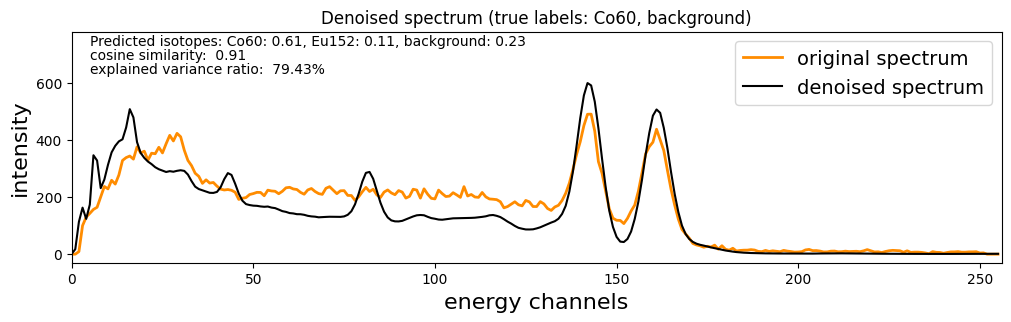

In plot_scores_scatter_matrix, only misclassified test data are displayed.


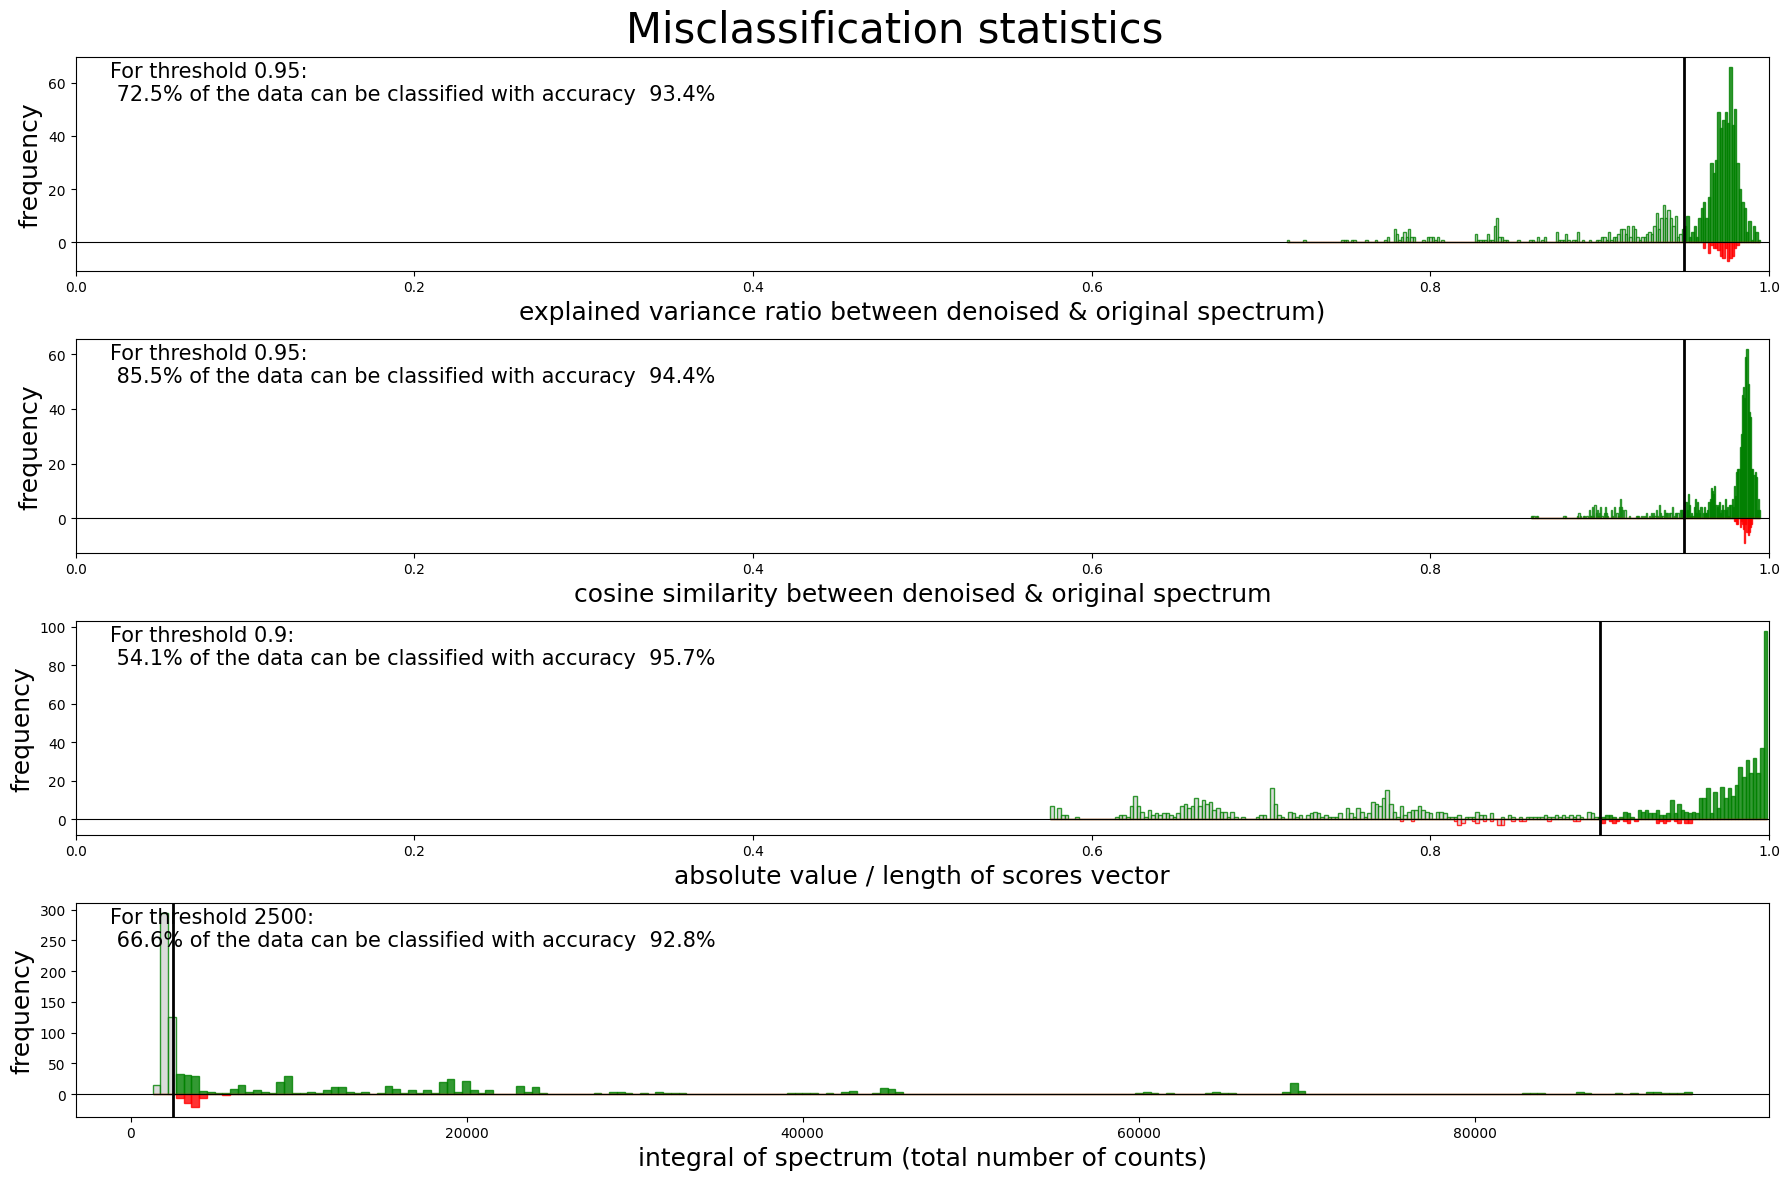

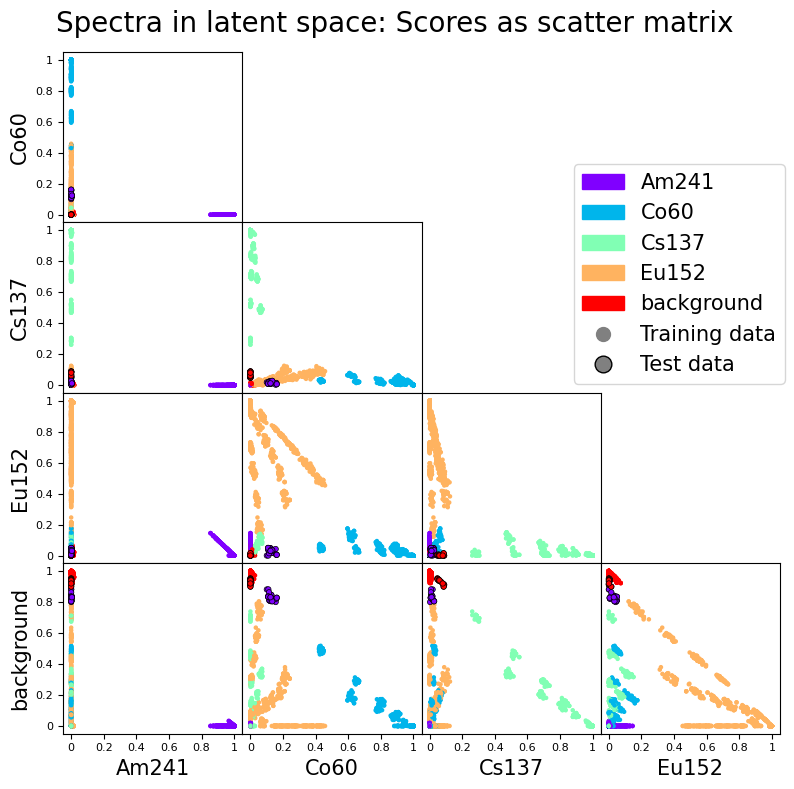

ratio of mean Am241 scores on Am241 axis: 0.72
ratio of mean Co60 scores on Co60 axis: 0.48
ratio of mean Cs137 scores on Cs137 axis: 0.37
ratio of mean Eu152 scores on Eu152 axis: 0.67
ratio of mean background scores on background axis: 0.97


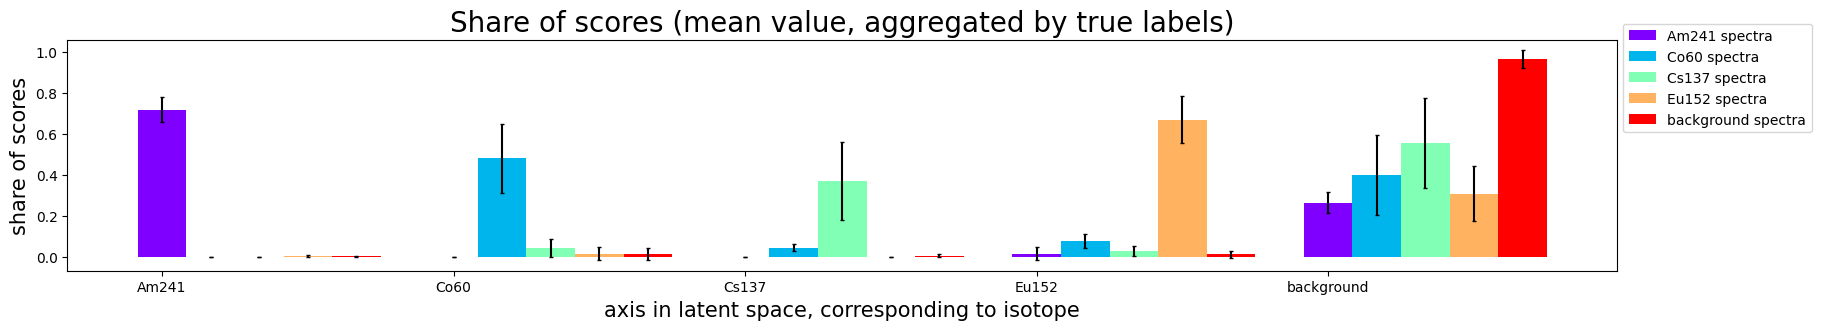

In [ ]:
# Single-label classification of unknown test dataset from different detector
# (e.g. measured spectra containing background)

# specify and load test data
dets_te = (
    GlobalVariables.dets_measured
)  # specify the detectors (e.g. only measured spectra: 'left' and 'right')
files_to_exclude = [
    "multi-class.npy"
]  # exclude multi-label dataset (containing multiple isotopes per spectra)
data_test_meas, isotopes_test_meas = load_spectral_data(
    dir_numpy_ready, dets_te, exclude_files=files_to_exclude
)

# optional: filter out outliers (data from isotopes that were not used in model training)
isotopes_test_meas = [
    isos for isos in isotopes_test_meas if np.all([iso in isotopes_tr for iso in isos])
]  # filter isotope_test
data_test_meas = [
    x for x in data_test_meas if x["labels"] in isotopes_test_meas
]  # filter measured test data

# limit the number of spectra per isotope
data_test_meas = limit_length_of_dataset(
    data_test_meas, n_spectra_max=1000
)  # limit to n_max test spectra per isotope
count_spectra_per_isotope(data_test_meas)

# transform spectra to latent space (calculate scores)
data_test_meas = transform_spectra(data_test_meas)

# transform scores from latent space back to get denoised spectra
data_test_meas, expl_var_te = denoise_spectra(data_test_meas)
print(f"explained variance ratio of unknown test dataset: {expl_var_te: .1%}")

# classify the spectra according to their scores
class_type_meas = "single-label"
data_test_meas = classify_from_scores(data_test_meas, class_type_meas)

"""# plot confusion matrix of true and predicted labels
plot_confusion_matrix(data_test_meas, class_type_meas, save_plot=True)

# misclassified spectrum and true & predicted means, denoised spectrum
plot_misclassified_spectra(data_test_meas, class_type_meas, save_plot=False)"""

# example spectrum (original & denoised)
plot_denoised_spectrum_example(data_test_meas)

"""# histogram of correct & incorrect classifications
plot_misclassification_statistics(data_test_meas, class_type_meas)
    
# scatter matrix of scores (data in latent space)
plot_scores_scatter_matrix(data_tr, data_test_meas, class_type_meas, n_dim_max=6, only_errs=True, save_plot=False)

# barplot of mean scores (for all isotopes)
plot_mean_scores_barplot(data_test_meas, class_type_meas, save_plot=False)  """

## Testing the model on spectral data from a different detector (multi-label spectra only) ##

Similar to the example above, the model can be inferenced on multi-label spectra from a detector not involved in model training. 

In our example, the relevant (preprocessed) dataset is `multi-class.npy` (with a corresponding isotope `multi-class` in `00_list_measured_isotopes`).  
It includes combinations of isotopes used in training but also outliers, i.e. isotopes unknown to the model. You can choose to filter them out with `filter_out_outliers = True`.


['Am241', 'Eu152', 'background']: 61 spectra
['Am241', 'background']: 13 spectra
['Co60', 'Cs137', 'background']: 182 spectra
['Co60', 'Eu152', 'background']: 155 spectra
['Co60', 'background']: 25 spectra
['Cs137', 'Eu152', 'background']: 65 spectra
['Cs137', 'background']: 64 spectra
['Eu152', 'background']: 32 spectra
['background']: 403 spectra
Explained variance ratio of unknown test dataset with multi-labels, filter_out_outliers=True:  94.8%
Mean multi-label-accuracy:  81.9% 

613 perfect multi-label-predictions ( 61.3%). 
261 incomplete, but only-correct multi-label-classifications ( 26.1%). 
25 complete, but partially wrong multi-label-classifications ( 2.5%). 
101 incomplete, partially wrong multi-label-classifications ( 10.1%). 


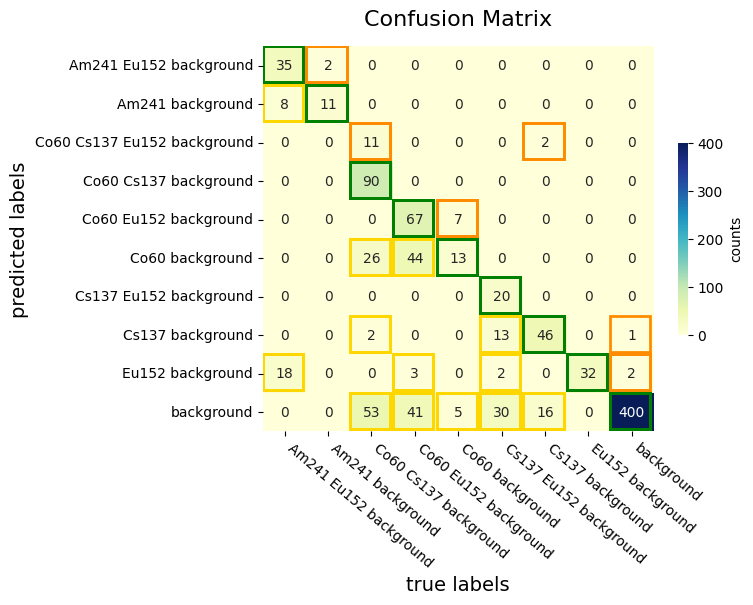

label_true='Cs137 background'
dict_keys(['background'])
label_true='Cs137 Eu152 background'
dict_keys(['background'])
label_true='Co60 Eu152 background'
dict_keys(['Co60', 'background'])


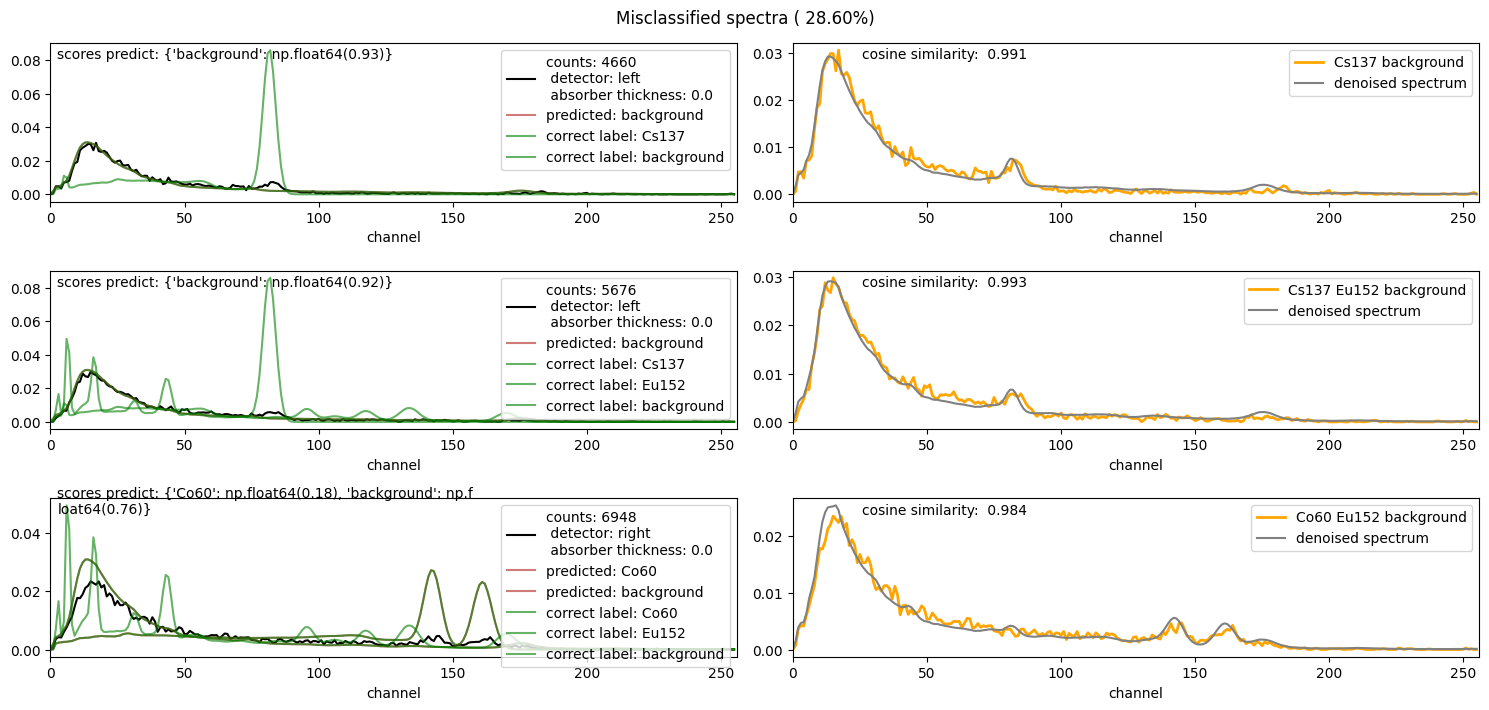

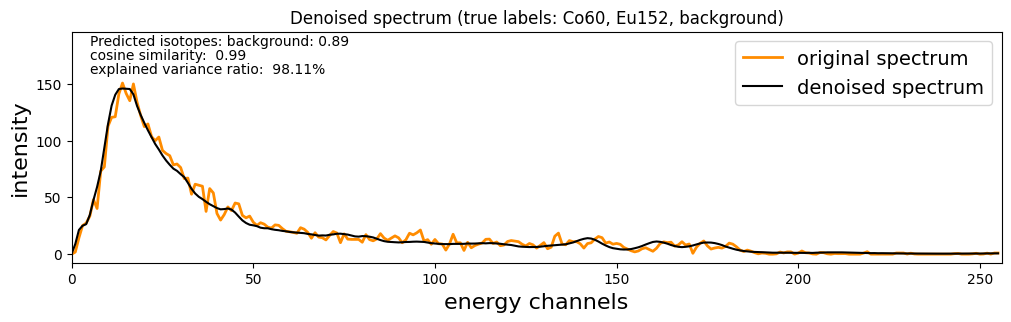

In plot_scores_scatter_matrix, only misclassified test data are displayed.
CAUTION: for the scores scatter matrix, colors only reflect the dominant component of multi-label spectra!


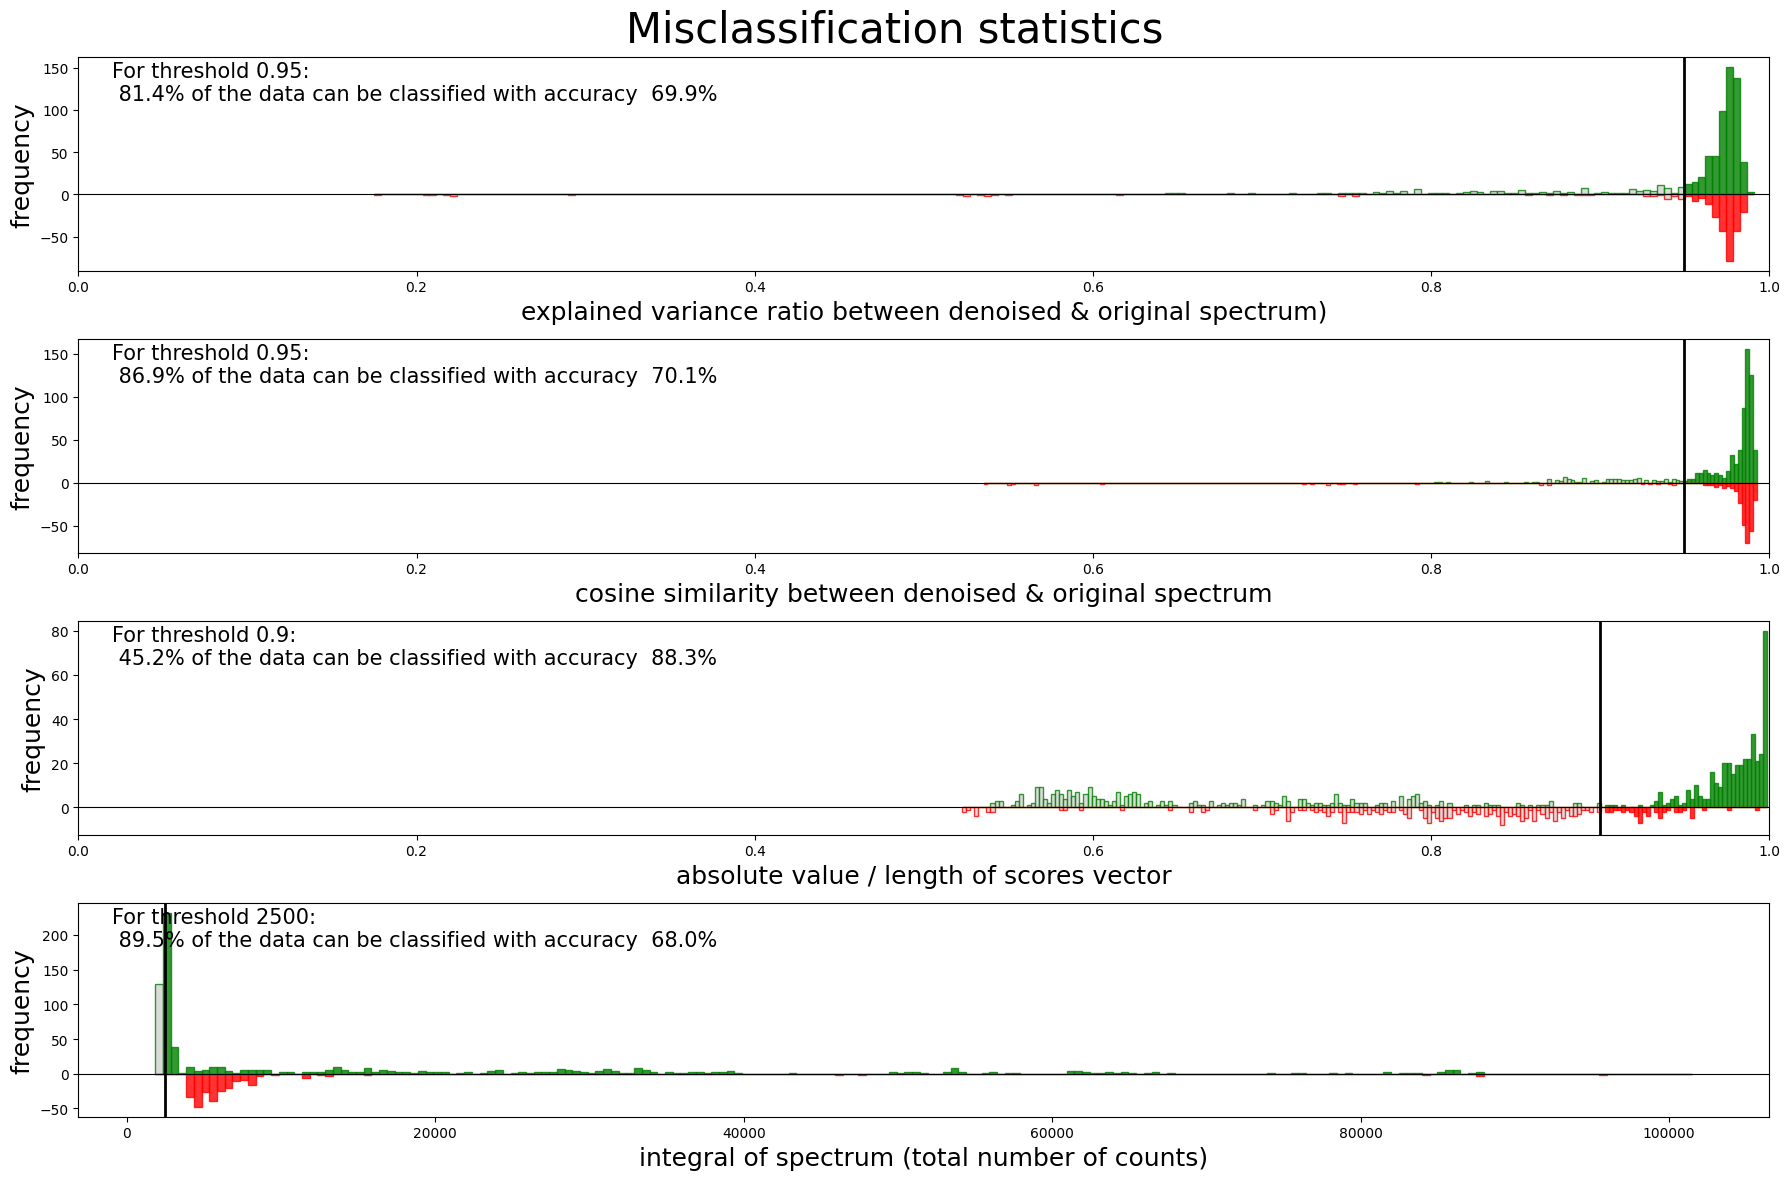

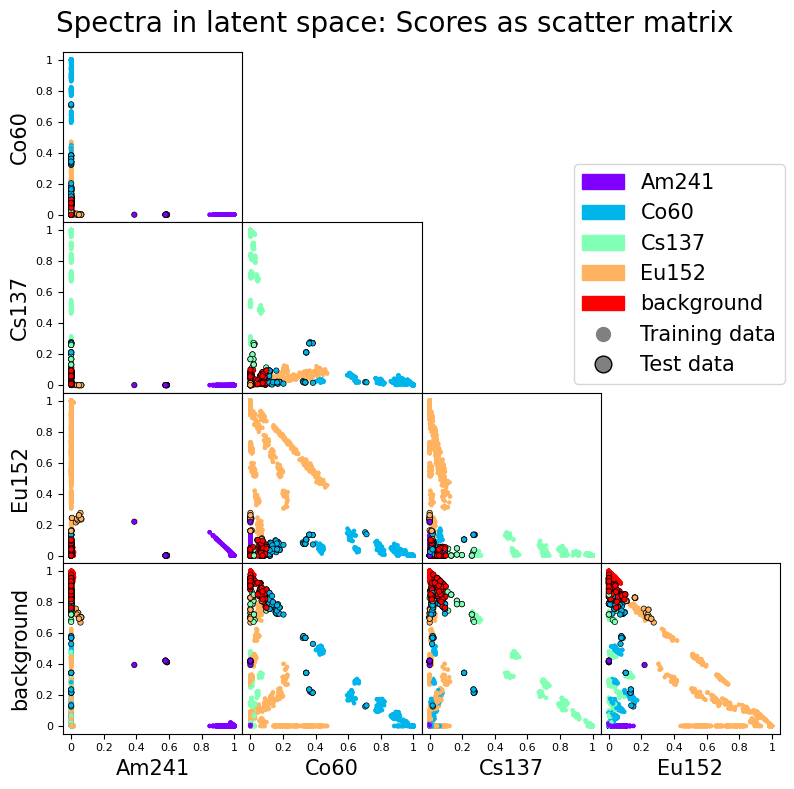

In [ ]:
# Multi-label classification of unknown test dataset (including isotopes that not used in training)

# specify and load test data
dets_test_multi = GlobalVariables.dets_measured
data_test_multi, isotopes_multi = load_spectral_data(
    dir_numpy_ready, dets_test_multi, include_files="multi-class.npy"
)

# optional: filter out outliers (data from isotopes that were not used in model training)
filter_out_outliers = True
if filter_out_outliers:
    data_test_multi = [
        x
        for x in data_test_multi
        if np.all([lab in isotopes_tr for lab in x["labels"]])
    ]  # only data of isotopes that were included in training data

# limit the number of spectra per isotope
data_test_multi = limit_length_of_dataset(
    data_test_multi, n_spectra_max=1000
)  # limit to n_spectra_max spectra per isotope
count_spectra_per_isotope(data_test_multi)

# transform spectra to latent space (calculate scores)
data_test_multi = transform_spectra(data_test_multi)

# transform scores from latent space back to get denoised spectra
data_test_multi, expl_var_multi = denoise_spectra(data_test_multi)
print(
    f"Explained variance ratio of unknown test dataset with multi-labels, {filter_out_outliers=}: {expl_var_multi: .1%}"
)

# classify the spectra according to their scores
class_type_multi = "multi-label"
data_test_multi = classify_from_scores(data_test_multi, class_type_multi)

"""# plot confusion matrix of true and predicted labels
plot_confusion_matrix(data_test_multi, class_type_multi, save_plot=False)

# misclassified spectrum and true & predicted means, denoised spectrum
plot_misclassified_spectra(data_test_multi, class_type_multi, save_plot=False)"""

# example spectrum (original & denoised)
plot_denoised_spectrum_example(data_test_multi)

"""# histogram of correct & incorrect classifications 
plot_misclassification_statistics(data_test_multi, class_type_multi)
    
# scatter matrix of scores (data in latent space)
plot_scores_scatter_matrix(data_tr, data_test_multi, class_type_multi, n_dim_max=6, only_errs=True, save_plot=False)"""